In [1]:
import torch
import torchvision as tv
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(0)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mnist_train = tv.datasets.MNIST(root='./data', train=True, download=True, transform=tv.transforms.ToTensor())

In [3]:
len(mnist_train)

60000

In [4]:
train = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


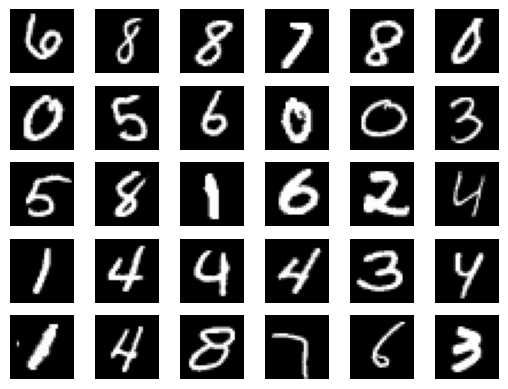

In [5]:
def show_n_images(images, m, n):
    fig, axs = plt.subplots(m, n)
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i].permute(1,2,0), cmap="gray")
        ax.axis('off')
    plt.show()

for b_img, b_labels in train:
	print(b_img.shape)
	print(b_labels.shape)
	show_n_images(b_img, 5, 6)
	break

In [6]:
class VanillaAE(nn.Module):
    def __init__(self, flat_input_dim=784, latent_dims=2):
        super().__init__()

        # encoder 
        self.enc_hidden1 = nn.Linear(flat_input_dim, 16)
        self.enc_latent = nn.Linear(16, latent_dims)

        # decoder
        self.dec_hidden1 = nn.Linear(latent_dims, 16)
        self.dec_recon = nn.Linear(16, flat_input_dim)
        
    def forward(self, x):
        """Assumes input of x is normalized between [0, 1] instead of [0, 255]"""

        # encode
        h1 = torch.relu(self.enc_hidden1(x))
        latent = self.enc_latent(h1) # code

        # decode
        h2 = torch.relu(self.dec_hidden1(latent))
        recon = torch.sigmoid(self.dec_recon(h2)) # back to what x looks like

        # compare x to the reconstruction
        loss = F.mse_loss(recon, x)

        return recon, latent, loss

model = VanillaAE()

100%|██████████| 1000/1000 [00:01<00:00, 625.43it/s]


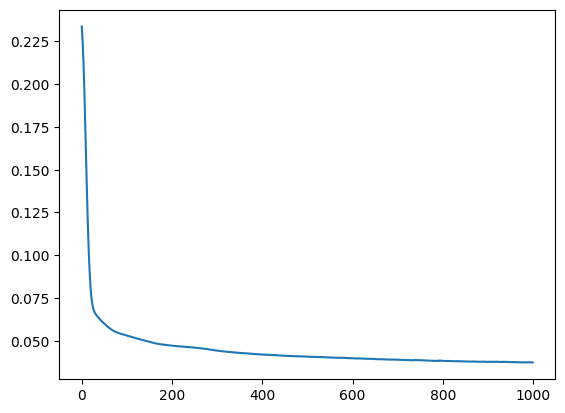

In [7]:
# overfit on a single batch
model = VanillaAE()
optim = torch.optim.AdamW(model.parameters(), lr=5e-3)
epochs = 1000
b_img, _ = next(iter(train))
losses = torch.zeros(epochs)
for i in tqdm(range(epochs)):
	optim.zero_grad()

	# forward pass
	_, _, loss = model(b_img.view(-1, 784))

	# backward pass and update
	loss.backward()
	optim.step()
	losses[i] = loss.item()

plt.plot(torch.arange(epochs), losses)

In [8]:
# now visualize the embedding space
@torch.no_grad()
def compute_embeddings(model, dataloader, times=float("inf")):
	latents = []
	labels = []
	times_acc = 0
	for i, (b_img, b_labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
		if times_acc >= times:
			break
		
		_, latent, _ = model(b_img.view(-1, 784))
		latents.extend(latent.tolist())
		labels.extend(b_labels.tolist())

		times_acc += 1

	return torch.tensor(latents), torch.tensor(labels)


latents, labels = compute_embeddings(model, train)

100%|██████████| 938/938 [00:07<00:00, 132.16it/s]


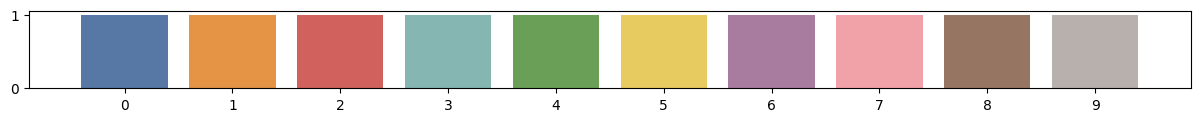

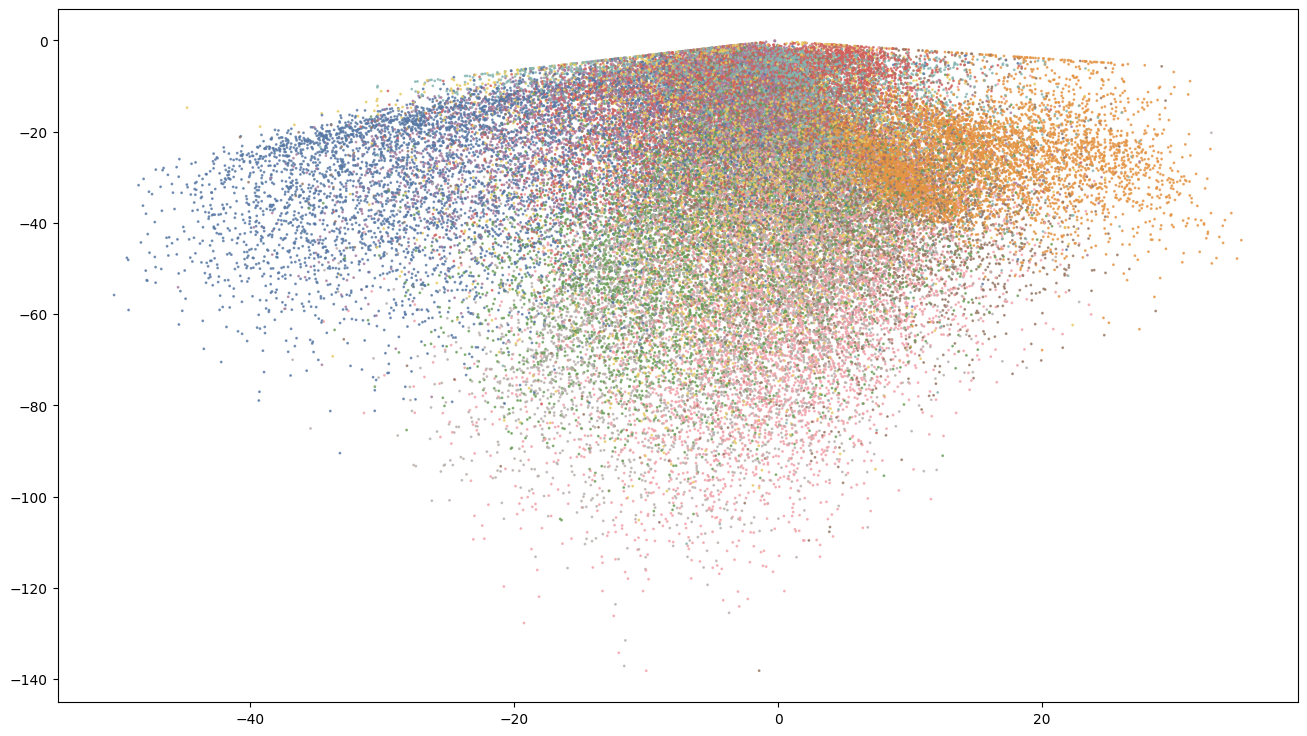

In [9]:
def custom_legend(colors, labels):
	fig, ax = plt.subplots()
	fig.set_figwidth(15)
	fig.set_figheight(1)
	ax.bar(labels, [1 for i in range(len(labels))], label=labels, color=colors)
	return ax

def plot_mnist(latents, labels):
	tab10 = ["#5778a4", "#e49444", "#d1615d", "#85b6b2", "#6a9f58", "#e7ca60", "#a87c9f", "#f1a2a9", "#967662", "#b8b0ac"]
	custom_legend(tab10, [str(i) for i in range(10)])
	plt.show()
	plt.figure(figsize=(16, 9))
	plt.scatter(latents[:, 0], latents[:, 1], c=[tab10[i] for i in labels.tolist()], s=1, alpha=0.75)
plot_mnist(latents, labels)

In [10]:
class BiggerVanillaAE(nn.Module):
    def __init__(self, flat_input_dim=784, latent_dims=2):
        super().__init__()

        # encoder 
        self.enc_hidden1 = nn.Linear(flat_input_dim, 256)
        self.enc_hidden2 = nn.Linear(256, 64)
        self.enc_latent = nn.Linear(64, latent_dims)

        # decoder
        self.dec_hidden1 = nn.Linear(latent_dims, 64)
        self.dec_hidden2 = nn.Linear(64, 256)
        self.dec_recon = nn.Linear(256, flat_input_dim)
        
    def forward(self, x):
        """Assumes input of x is normalized between [0, 1] instead of [0, 255]"""

        # encode
        h1 = torch.relu(self.enc_hidden1(x))
        h2 = torch.relu(self.enc_hidden2(h1))
        latent = self.enc_latent(h2) # code

        # decode
        h3 = torch.relu(self.dec_hidden1(latent))
        h4 = torch.relu(self.dec_hidden2(h3))
        recon = torch.sigmoid(self.dec_recon(h4)) # back to what x looks like

        # compare x to the reconstruction
        loss = F.mse_loss(recon, x)

        return recon, latent, loss

model_bigger = BiggerVanillaAE()
model_bigger

BiggerVanillaAE(
  (enc_hidden1): Linear(in_features=784, out_features=256, bias=True)
  (enc_hidden2): Linear(in_features=256, out_features=64, bias=True)
  (enc_latent): Linear(in_features=64, out_features=2, bias=True)
  (dec_hidden1): Linear(in_features=2, out_features=64, bias=True)
  (dec_hidden2): Linear(in_features=64, out_features=256, bias=True)
  (dec_recon): Linear(in_features=256, out_features=784, bias=True)
)

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:10<00:00, 89.10it/s] 


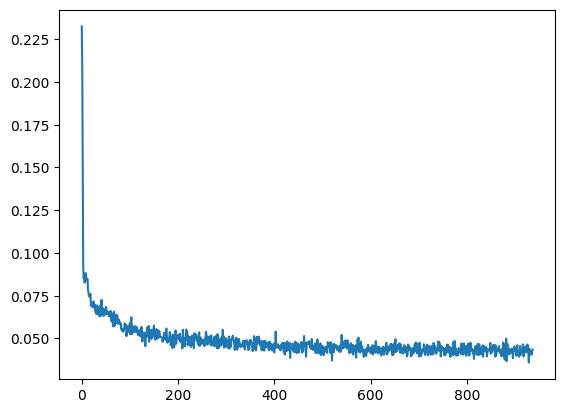

In [11]:
# overfit on a single batch
model_bigger = BiggerVanillaAE()
optim = torch.optim.AdamW(model_bigger.parameters(), lr=5e-3)
epochs = 1
losses = []
for i in range(epochs):
	for b_img, _ in tqdm(train):
		optim.zero_grad()

		# forward pass
		_, _, loss = model_bigger(b_img.view(-1, 784))

		# backward pass and update
		loss.backward()
		optim.step()
		losses.append(loss.item())

plt.plot(losses)

100%|██████████| 938/938 [00:06<00:00, 138.69it/s]


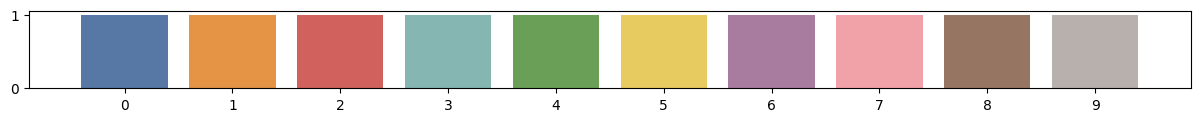

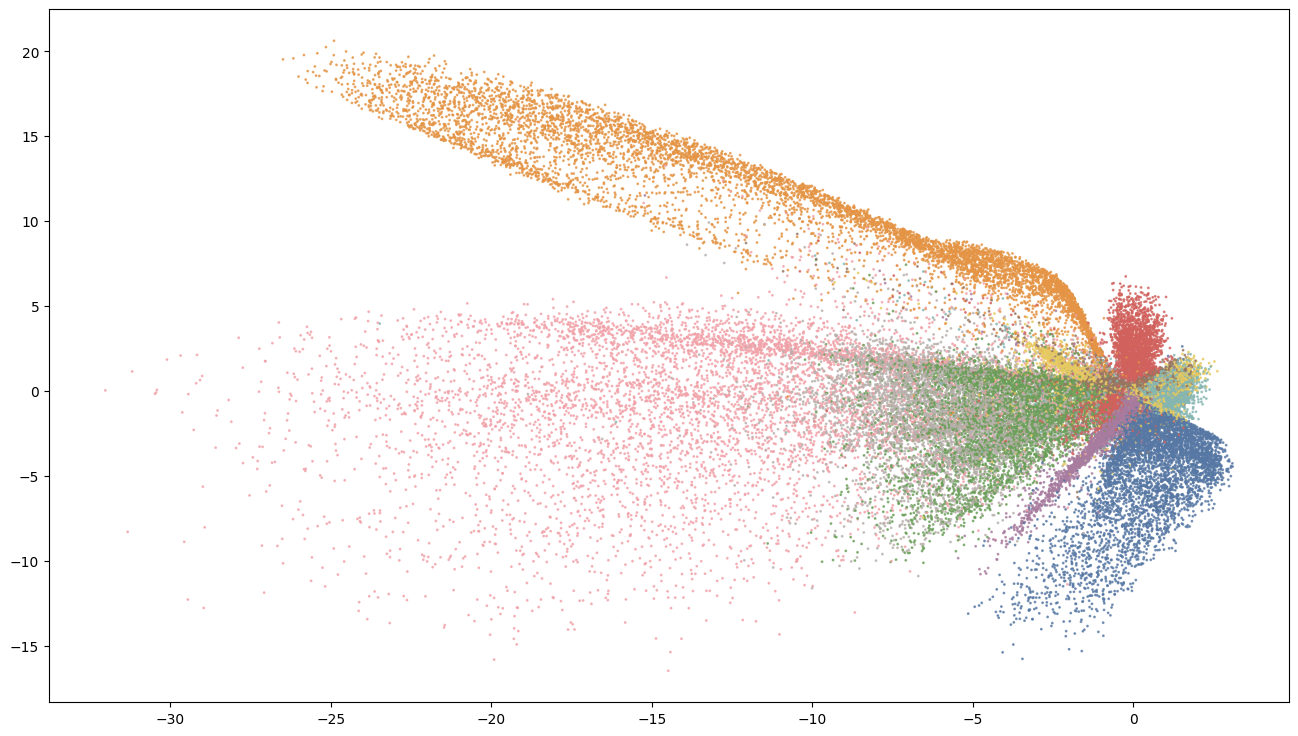

In [12]:
latents, labels = compute_embeddings(model_bigger, train)
plot_mnist(latents, labels)

100%|██████████| 938/938 [00:10<00:00, 88.79it/s] 


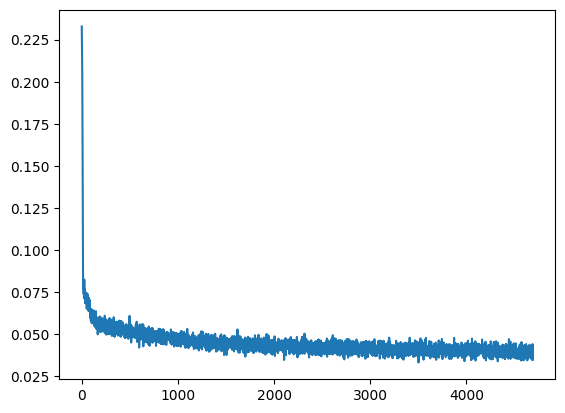

100%|██████████| 938/938 [00:06<00:00, 147.15it/s]


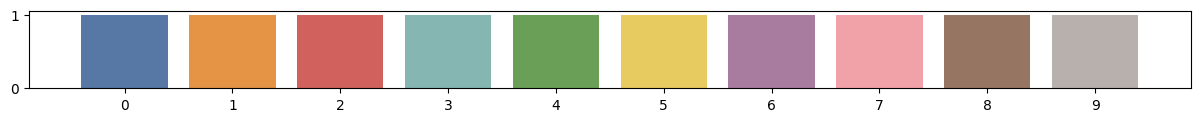

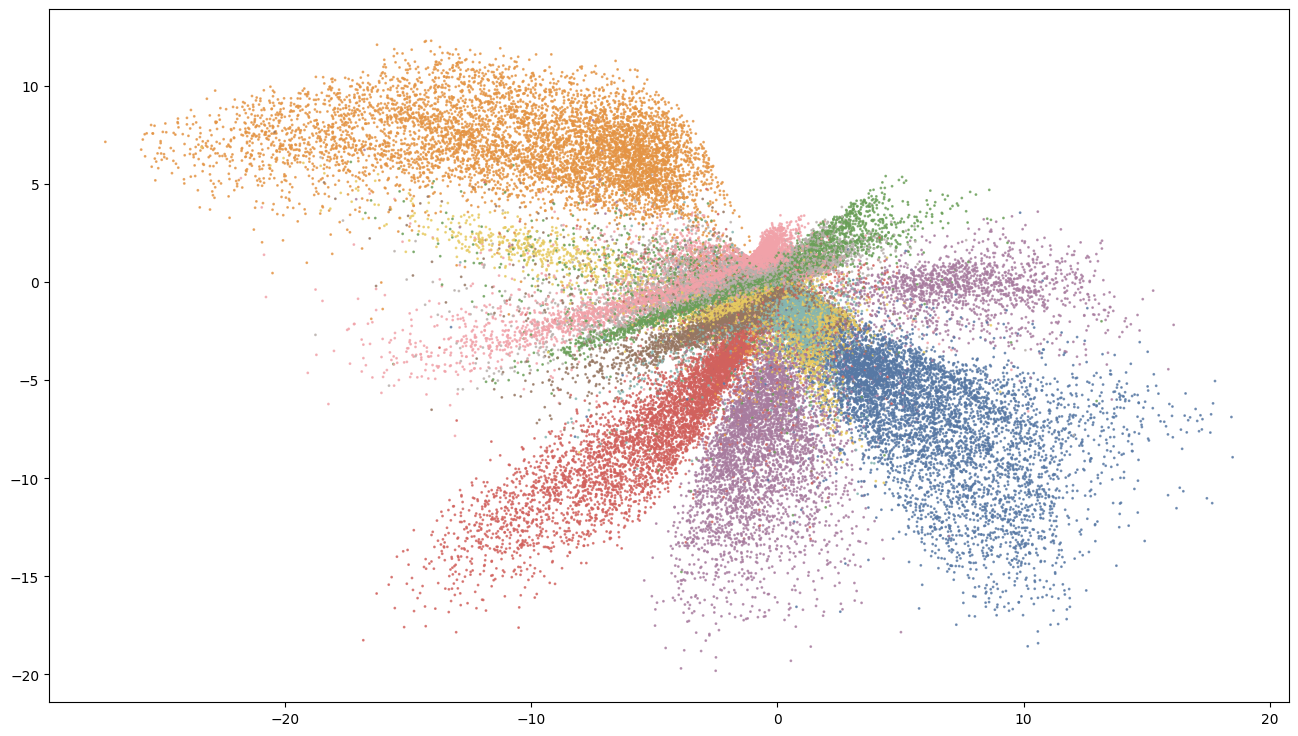

In [13]:
# overfit on a single batch
model_bigger = BiggerVanillaAE()
optim = torch.optim.AdamW(model_bigger.parameters(), lr=1e-3)
epochs = 5
losses = []
for i in range(epochs):
	for b_img, _ in tqdm(train):
		optim.zero_grad()

		# forward pass
		_, _, loss = model_bigger(b_img.view(-1, 784))

		# backward pass and update
		loss.backward()
		optim.step()
		losses.append(loss.item())

plt.plot(losses)
plt.show()
latents, labels = compute_embeddings(model_bigger, train)
plot_mnist(latents, labels)

100%|██████████| 938/938 [00:09<00:00, 95.65it/s] 


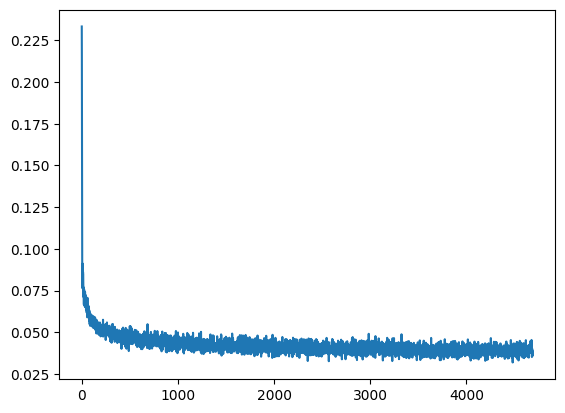

100%|██████████| 938/938 [00:06<00:00, 152.63it/s]


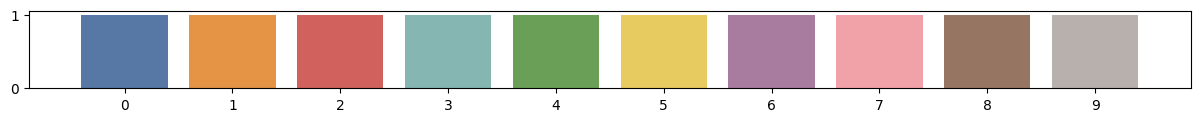

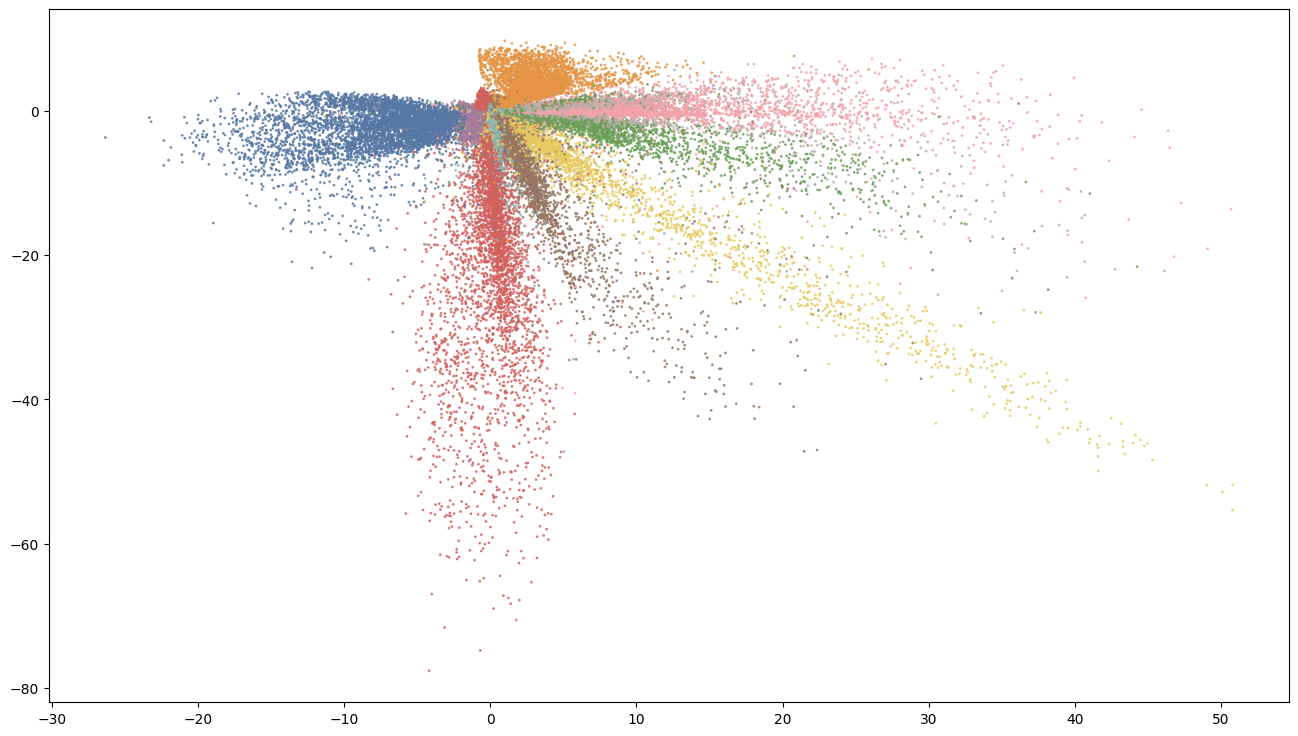

In [15]:
# overfit on a single batch
model_bigger = BiggerVanillaAE()
optim = torch.optim.AdamW(model_bigger.parameters(), lr=5e-3)
epochs = 5
losses = []
for i in range(epochs):
	for b_img, _ in tqdm(train):
		optim.zero_grad()

		# forward pass
		_, _, loss = model_bigger(b_img.view(-1, 784))

		# backward pass and update
		loss.backward()
		optim.step()
		losses.append(loss.item())

plt.plot(losses)
plt.show()
latents, labels = compute_embeddings(model_bigger, train)
plot_mnist(latents, labels)